In [9]:
# Download data if not present
import os
if not os.path.exists('../data'):
    from python_scripts.onedrive_helper import *
    oh = OneDriveHelper()
    oh.download('data', '../')

In [10]:
import tensorflow as tf

gpu_amount = len(tf.config.experimental.list_physical_devices('GPU'))
print(f'GPU acceleration enabled = {gpu_amount > 0}')

GPU acceleration enabled = False


In [11]:
input_dir = "../data/Model Input Data/Amazon/Inputs/"
target_dir = "../data/Model Input Data/Amazon/Targets/"
img_size = (512, 512)
num_classes = 2
batch_size = 1

input_img_paths = sorted([
    os.path.join(input_dir, fname) 
    for fname in os.listdir(input_dir) 
    if fname.endswith(".png")])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 27
../data/Model Input Data/Amazon/Inputs/Amazon_1110.png | ../data/Model Input Data/Amazon/Targets/Amazon_1110.tiff_25.png
../data/Model Input Data/Amazon/Inputs/Amazon_1154.png | ../data/Model Input Data/Amazon/Targets/Amazon_1154.tiff_40.png
../data/Model Input Data/Amazon/Inputs/Amazon_122.png | ../data/Model Input Data/Amazon/Targets/Amazon_122.tiff_33.png
../data/Model Input Data/Amazon/Inputs/Amazon_124.png | ../data/Model Input Data/Amazon/Targets/Amazon_124.tiff_36.png
../data/Model Input Data/Amazon/Inputs/Amazon_1279.png | ../data/Model Input Data/Amazon/Targets/Amazon_1279.tiff_29.png
../data/Model Input Data/Amazon/Inputs/Amazon_1377.png | ../data/Model Input Data/Amazon/Targets/Amazon_1377.tiff_12.png
../data/Model Input Data/Amazon/Inputs/Amazon_1561.png | ../data/Model Input Data/Amazon/Targets/Amazon_1561.tiff_37.png
../data/Model Input Data/Amazon/Inputs/Amazon_170.png | ../data/Model Input Data/Amazon/Targets/Amazon_170.tiff_38.png
../data/Model In

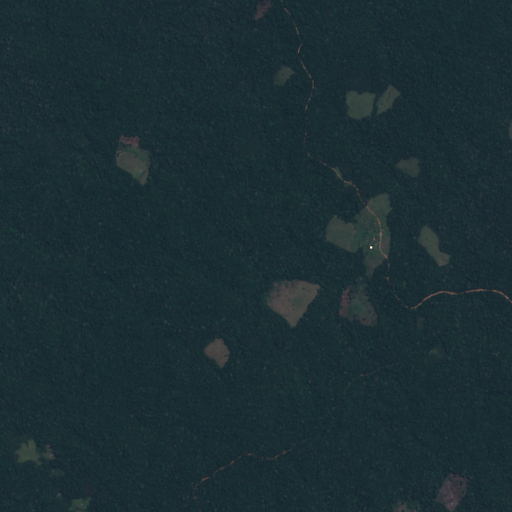

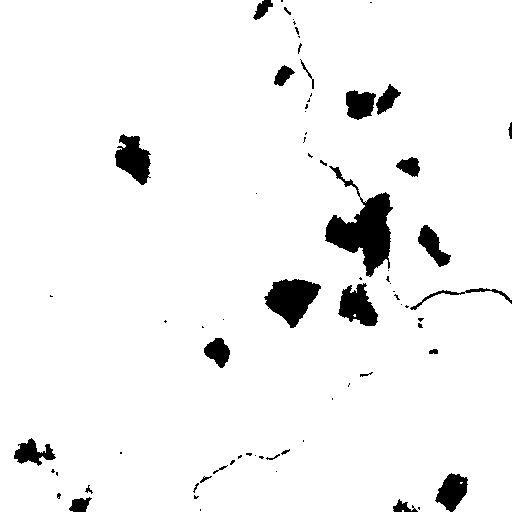

In [12]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
from matplotlib import pyplot as plt
import random as rnd

i = rnd.randrange(0, len(input_img_paths) - 1)

# Displays random input image
display(Image(filename=input_img_paths[i]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
display(img)

In [13]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class SatelliteImages(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size)
            data = np.array(img)[:, :, 0]
            data = np.expand_dims(data, 2)
            y[j] = data
            y[j] = np.divide(y[j], 255)
        return x, y

In [35]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [36]:
import random

# Split our img paths into a training and a validation set using 80/20 split
val_samples = int(len(input_img_paths) * 0.2)
seed = 1337
random.Random(seed).shuffle(input_img_paths)
random.Random(seed).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = SatelliteImages(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [37]:
# Custom Metric functions
def custom_pixel_accuracy(y_true, y_pred):
    """Returns the pixel accuracy between a given ground truth and a semantic segmentation mask.
    Please note that this metric is NOT robust; non-classified areas are also taken into account (if they exist).
    As such it works best when coupled with other metrics such as precision, recall and F1 score."""
    

In [38]:
# smpl_train = next(iter(train_gen))
# smpl_val = next(iter(val_gen))
# x_train, y_train, x_val, y_val = smpl_train[0], smpl_train[1], smpl_val[0], smpl_val[1]
# display(x_train.shape)
# display(y_train.shape)
# display(x_val.shape)
# display(y_val.shape)
# display(y_val[0][0][0].shape)

In [39]:
# test = y_val.copy()
# test = test.reshape((5,512,512))
# test2 = x_val.copy()
# test2.reshape((5,512,512,3))

In [41]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
from tensorflow.keras.metrics import MeanIoU
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",metrics=[MeanIoU(2)])
callbacks = [keras.callbacks.ModelCheckpoint("image_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 25
reshistory = model.fit(train_gen, epochs=epochs, callbacks=callbacks, validation_data=val_gen)

Epoch 1/25


InvalidArgumentError:  Shapes of all inputs must match: values[0].shape = [262144] != values[1].shape = [524288]
	 [[node confusion_matrix/stack_1 (defined at <ipython-input-41-89bc26212f38>:10) ]] [Op:__inference_train_function_30588]

Function call stack:
train_function


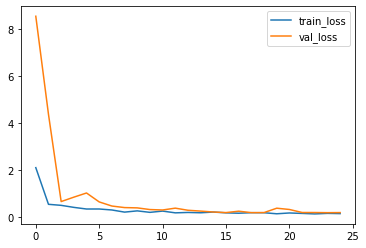

In [22]:
plt.plot(reshistory.history['loss'],label="train_loss")
plt.plot(reshistory.history['val_loss'],label="val_loss")
# plt.plot(reshistory.history['accuracy'],label="train_accuracy")
# plt.plot(reshistory.history['val_accuracy'],label="val_accuracy")
plt.legend()
plt.show()

In [ ]:
# # Hyperas: Automatische hyperparameter optimalisering, voor keras, met behulp van hyperopt.
# # https://github.com/maxpumperla/hyperas

# from hyperopt import STATUS_OK, Trials, tpe

# from hyperas import optim
# from hyperas.distributions import choice, uniform

# def get_data_hyperas():
#     input_dir = "../data/Model Input Data/Amazon/Inputs/"
#     target_dir = "../data/Model Input Data/Amazon/Targets/"
#     img_size = (512, 512)
#     num_classes = 2
#     batch_size = 1

#     input_img_paths = sorted([
#         os.path.join(input_dir, fname) 
#         for fname in os.listdir(input_dir) 
#         if fname.endswith(".png")])

#     target_img_paths = sorted([
#         os.path.join(target_dir, fname)
#         for fname in os.listdir(target_dir)
#         if fname.endswith(".png") and not fname.startswith(".")])

#     for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
#         print(input_path, "|", target_path)
        
#     val_samples = int(len(input_img_paths) * 0.2)
#     seed = 1337
#     random.Random(seed).shuffle(input_img_paths)
#     random.Random(seed).shuffle(target_img_paths)
#     train_input_img_paths = input_img_paths[:-val_samples]
#     train_target_img_paths = target_img_paths[:-val_samples]
#     val_input_img_paths = input_img_paths[-val_samples:]
#     val_target_img_paths = target_img_paths[-val_samples:]

#     # Instantiate data Sequences for each split
#     train_gen = SatelliteImages(batch_size, img_size, train_input_img_paths, train_target_img_paths)
#     val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)
    
#     # Itereer over de database objecten en zet ze in een lijst voor hyperopt/hyperas.
#     # Elk object retourneert telkens een x, y.
#     x_train, y_train, x_test, y_test = []
#     for i in range(train_gen.__len__()):
#         x, y = train_gen.__getitem__(i)
        
#     return 

# def get_model_hyperas():
#     """Gets, trains and optimizes a model's hyperparameters prior to returning."""
    
#     img_size = (512, 512)
#     num_classes = 2
    
#     # STAGE 1: GET THE MODEL
    
#     inputs = keras.Input(shape=img_size + (3,))

#     ### [First half of the network: downsampling inputs] ###

#     # Entry block
#     x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     # Blocks 1, 2, 3 are identical apart from the feature depth.
#     for filters in [64, 128, 256]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     ### [Second half of the network: upsampling inputs] ###

#     for filters in [256, 128, 64, 32]:
#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.UpSampling2D(2)(x)

#         # Project residual
#         residual = layers.UpSampling2D(2)(previous_block_activation)
#         residual = layers.Conv2D(filters, 1, padding="same")(residual)
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     # Add a per-pixel classification layer
#     outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

#     # Define the model
#     h_model = keras.Model(inputs, outputs)
    
#     # STAGE 2: GET THE DATA
    
#     val_samples = int(len(input_img_paths) * 0.2)
#     seed = 1337
#     random.Random(seed).shuffle(input_img_paths)
#     random.Random(seed).shuffle(target_img_paths)
#     train_input_img_paths = input_img_paths[:-val_samples]
#     train_target_img_paths = target_img_paths[:-val_samples]
#     val_input_img_paths = input_img_paths[-val_samples:]
#     val_target_img_paths = target_img_paths[-val_samples:]

#     # Instantiate data Sequences for each split
#     train_gen = SatelliteImages(batch_size, img_size, train_input_img_paths, train_target_img_paths)
#     val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)
    
#     # STAGE 3: FIT THE MODEL
    
#     # Configure the model for training.
#     # We use the "sparse" version of categorical_crossentropy
#     # because our target data is integers.
#     h_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
#     # callbacks = [keras.callbacks.ModelCheckpoint("image_segmentation.h5", save_best_only=True)]

#     # Train the model, doing validation at the end of each epoch.
#     epochs = 25
#     reshistory = h_model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)
    
#     best = min(reshistory.history['val_loss'])  # Get the best loss. This is returned.
    
#     return {'loss':best,'status':STATUS_OK,'model':model}

# # hyperasmodel = get_model_hyperas(img_size, num_classes)
# best_run, hyperasmodel = optim.minimize(model=get_model_hyperas,
#                               data=get_data_hyperas,
#                               algo=tpe.suggest,
#                               max_evals=5,
#                               trials=Trials())

In [ ]:
# Generate predictions for all images in the validation set

val_gen = SatelliteImages(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #0
i = rnd.randrange(0, len(val_input_img_paths) - 1)

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [ ]:
# Hyperparameter optimalisation;
# Here we define a couple of variations of the model above with slight adjustments to the hyperparameters/structure
# The performance of these models is analysed to determine the best model architecture for our current problem.

In [23]:
def alt_model_1(img_size, num_classes):
    """Alternative model getter that emphasises on additional filters."""
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(64, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


def alt_model_2(img_size, num_classes):
    """Alternate model getter that emphasises on a additional up/downsampling layer"""
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [512, 256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [24]:
# Model trialing.

models = [{"name":"baseline","model":get_model,"opt":"rmsprop"},
          {"name":"filters","model":alt_model_1,"opt":"rmsprop"},
          {"name":"up-downsampling","model":alt_model_2,"opt":"rmsprop"}]

Epoch 1/2
22/22 [==============================] - 31s 1s/step - loss: 6.3778 - val_loss: 31.4406
Epoch 2/2
22/22 [==============================] - 28s 1s/step - loss: 0.7395 - val_loss: 14.3092
Epoch 1/2
22/22 [==============================] - 80s 3s/step - loss: 15.2334 - val_loss: 32.4568
Epoch 2/2
22/22 [==============================] - 81s 4s/step - loss: 0.5938 - val_loss: 13.6580
Epoch 1/2
22/22 [==============================] - 45s 2s/step - loss: 8.7616 - val_loss: 36.3981
Epoch 2/2
22/22 [==============================] - 37s 2s/step - loss: 0.6731 - val_loss: 20.1023


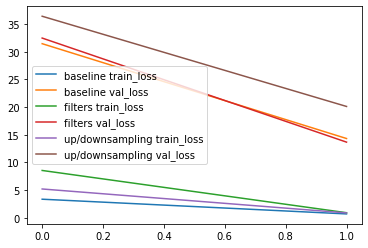

In [46]:
for entry in models:
    ho_model = entry["model"](img_size, num_classes)
    ho_model.compile(optimizer=entry["opt"], loss="sparse_categorical_crossentropy")
    callbacks = [keras.callbacks.ModelCheckpoint("image_segmentation_{}.h5".format(entry["name"]), save_best_only = True)]
    outcome = ho_model.fit(train_gen, epochs=2, callbacks=callbacks, validation_data=val_gen)
    plt.plot(outcome.history["loss"],label="{} train_loss".format(entry["name"]))
    plt.plot(outcome.history["val_loss"],label="{} val_loss".format(entry["name"]))
plt.legend()
plt.show()